# CMI - Detect Behavior With Sensor Data -- Initial Exploration

## Key Points From the Overview

### **Competition Details**

**The goal of this competition is to develop a predictive model that distinguishes BFRB-like and non-BFRB-like activity using data from a variety of sensors collected via a wrist-worn device. Successfully disentangling these behaviors will improve the design and accuracy of wearable BFRB-detection devices, which are relevant to a wide range of mental illnesses, ultimately strengthening the tools available to support their treatment.**

- To investigate BFRBs, the Child Mind Institute has developed a wrist-worn device, Helios, designed to detect these behaviors. While many commercially available devices contain Inertial Measurement Units (IMUs) to measure rotation and motion, the Helios watch integrates additional sensors, including 5 thermopiles (for detecting body heat) and 5 time-of-flight sensors (for detecting proximity). See the figure to the right for the placement of these sensors on the Helios device.

#### `Experiment`
- They began a transition from “rest” position and moved their hand to the appropriate location (Transition);
- They followed this with a short pause wherein they did nothing (Pause); and
- Finally they performed a gesture from either the BFRB-like or non-BFRB-like category of movements.
- Each participant performed 18 unique gestures (8 BFRB-like gestures and 10 non-BFRB-like gestures) in at least 1 of 4 different body-positions (sitting, sitting leaning forward with their non-dominant arm resting on their leg, lying on their back, and lying on their side).

#### `Challenge`

- This competition challenges you to develop a predictive model capable of distinguishing (1) BFRB-like gestures from non-BFRB-like gestures and (2) the specific type of BFRB-like gesture. 
- **Critically, when your model is evaluated, half of the test set will include only data from the IMU, while the other half will include all of the sensors on the Helios device (IMU, thermopiles, and time-of-flight sensors).**
- Your solutions will have direct real-world impact, as the insights gained will inform design decisions about sensor selection — specifically whether the added expense and complexity of thermopile and time-of-flight sensors is justified by significant improvements in BFRB detection accuracy compared to an IMU alone. 
    - By helping us determine the added value of these thermopiles and time-of-flight sensors, your work will guide the development of better tools for detection and treatment of BFRBs.


### **Data**

**`Types of Gestures`** 

- 8 BFRB
- 10 non- BFRB gestures

**`Helios Sensors + Hidden Test Set Info`**

- 1x Inertial Measurement Unit (IMU; BNO080/BNO085): An integrated sensor that combines accelerometer, gyroscope, and magnetometer measurements with onboard processing to provide orientation and motion data.
- 5x Thermopile Sensor (MLX90632): A non-contact temperature sensor that measures infrared radiation.
- 5x Time-of-Flight Sensor (VL53L7CX): A sensor that measures distance by detecting how long it takes for emitted infrared light to bounce back from objects.
- 3,500 sequences in the hidden test set.
- **Half of the hidden-test sequences are recorded with IMU only; the thermopile (thm_) and time-of-flight (tof__v*) columns are still present but contain null values for those sequences.**

**`Features / Columns to be Mindfull Of`**

- **sequence_type** target or non target gesture - train only.
- **gesture** `target column` - description of sequence gesture. train only.
- **orientation** subject orientation during sequence - train only.


## Initial EDA

In [1]:
from numba import cuda
print(cuda.gpus) # Test for GPU

<Managed Device 0>


In [9]:
from pathlib import Path
import pickle, gzip, os, time, shutil, subprocess, zipfile, gc
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cudf # Consistent dataframe merge errors revert to pandas for EDA and FE

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 1000):
        display(df)

In [4]:
## Move to utils
def download_data(competition:str, base_path: Path):
    data_path = base_path/'data'
    zip_path = data_path / f"{competition}.zip"
    
    data_path.mkdir(parents=True, exist_ok=False)
    print(f"Downloading data for competition: {competition}...")
    try:
        command = [
            "kaggle", "competitions", "download",
            "-c", competition,
            "-p", str(data_path),
            "--force"
            ]
        result = subprocess.run(
            command,
            check=True,
            text=True,
            encoding='utf-8'
        )
        print("Kaggle API Output: ", result.stdout)
    except FileNotFoundError: 
        print("'kaggle' command not found")
        return
    except subprocess.CalledProcessError as e:
        print(f"Error downloading data. Kaggle returned an API error: {e}")
        return

    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(data_path)
        print("Unzipping Complete.")
    except zipfile.BadZipFile:
        print(f"Error: Failed to unzip {zip_path}. The file may be corrupted.")
        return
    
    os.remove(zip_path)
        

In [5]:
competition_name = "cmi-detect-behavior-with-sensor-data"
project_dir = Path(os.path.expanduser("~/code/kaggle/kaggle-cmi-detect-behavior"))

#download_data(competition_name, project_dir)

Loading training data...

In [16]:
train_path = project_dir/'data/train.csv'
train_demo_path = project_dir/'data/train_demographics.csv'
test_path = project_dir/'data/test.csv'
test_demo_path =project_dir/'data/test_demographics.csv'

#Load DFs
train = pd.read_csv(train_path)
train_demo = pd.read_csv(train_demo_path)

### Analyzing `train`

In [17]:
display_all(train.head())

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,110.0,87.0,126.0,-1.0,-1.0,-1.0,-1.0,-1.0,137.0,108.0,115.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,128.0,110.0,129.0,140.0,-1.0,126.0,131.0,-1.0,-1.0,-1.0,108.0,122.0,139.0,113.0,121.0,-1.0,118.0,96.0,-1.0,-1.0,-1.0,-1.0,165.0,124.0,100.0,102.0,119.0,-1.0,-1.0,

In [18]:
# Get null percentages per column
null_info = [(col, train[col].isnull().sum(), (train[col].isnull().sum() / len(train))*100)
             for col in train.columns if train[col].isnull().any()]

for col, cnt, perc in null_info:
    print(f"{col}: {cnt} nulls ({perc:.2f}%)")
print(train.shape)

rot_w: 3692 nulls (0.64%)
rot_x: 3692 nulls (0.64%)
rot_y: 3692 nulls (0.64%)
rot_z: 3692 nulls (0.64%)
thm_1: 6987 nulls (1.22%)
thm_2: 7638 nulls (1.33%)
thm_3: 6472 nulls (1.13%)
thm_4: 6224 nulls (1.08%)
thm_5: 33286 nulls (5.79%)
tof_1_v0: 6224 nulls (1.08%)
tof_1_v1: 6224 nulls (1.08%)
tof_1_v2: 6224 nulls (1.08%)
tof_1_v3: 6224 nulls (1.08%)
tof_1_v4: 6224 nulls (1.08%)
tof_1_v5: 6224 nulls (1.08%)
tof_1_v6: 6224 nulls (1.08%)
tof_1_v7: 6224 nulls (1.08%)
tof_1_v8: 6224 nulls (1.08%)
tof_1_v9: 6224 nulls (1.08%)
tof_1_v10: 6224 nulls (1.08%)
tof_1_v11: 6224 nulls (1.08%)
tof_1_v12: 6224 nulls (1.08%)
tof_1_v13: 6224 nulls (1.08%)
tof_1_v14: 6224 nulls (1.08%)
tof_1_v15: 6224 nulls (1.08%)
tof_1_v16: 6224 nulls (1.08%)
tof_1_v17: 6224 nulls (1.08%)
tof_1_v18: 6224 nulls (1.08%)
tof_1_v19: 6224 nulls (1.08%)
tof_1_v20: 6224 nulls (1.08%)
tof_1_v21: 6224 nulls (1.08%)
tof_1_v22: 6224 nulls (1.08%)
tof_1_v23: 6224 nulls (1.08%)
tof_1_v24: 6224 nulls (1.08%)
tof_1_v25: 6224 nulls (1.

In [19]:
# Unique counts per sequence
print(f"Number of unique sequences: {train['sequence_id'].nunique()}")
print(f"Number of unique subjects : {train['subject'].nunique()}")
print(f"Number of unique gestures(target): {train['gesture'].nunique()}")

Number of unique sequences: 8151
Number of unique subjects : 81
Number of unique gestures(target): 18


In [29]:
display_all(train.describe())

,sequence_counter,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
count,574945.000000,574945.000000,574945.000000,574945.000000,571253.000000,571253.000000,571253.000000,571253.000000,567958.000000,567307.000000,568473.000000,568721.000000,541659.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.000000,568721.00000

#### Initial takeaways

- With 81 individual subjects and 18 unique gestures per subject, this is a non-trivial multi-class problem.
- Looking at NaN values per column, there appear to be two distinct types of sensor failures:
    - **Intermittent Failures** `rot_*` [quarternions](https://en.wikipedia.org/wiki/Quaternion), `thm_1-4` and `tof_1-4` sensors exhibit low and consistent NaN percentages (~0.64 and ~1.08%). Could this possibly be because of sporadic, temporary loss of communication from specific sensor chips?
    - **Systematic Failure** `thm_5` and all of `tof_5` pixels have a much higher and identical failure rate (~5.5%). Suggesting, quite strongly, that the fifth group of sensors is less reliable or could have been partially disabled on some devices.
- For many of the `tof_*` pixels the 25th, and sometimes the 50th, percentiles are -1.
    - This indicates that -1 is not an outlier but a frequent state representing "no object detected in range". This is fundamental to the data.
    - The value must be treated carefully. During feature engineering statistics need to be calculated for both with -1 and without -1 values.
- Moving to categorical variables, the `phase` column (Transition, Pause and Gesture) segments the behaviour within a sequence.

### Analyzing `test demographics`

In [21]:
train_demo.head()

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


In [22]:
train_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               81 non-null     object 
 1   adult_child           81 non-null     int64  
 2   age                   81 non-null     int64  
 3   sex                   81 non-null     int64  
 4   handedness            81 non-null     int64  
 5   height_cm             81 non-null     float64
 6   shoulder_to_wrist_cm  81 non-null     int64  
 7   elbow_to_wrist_cm     81 non-null     float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.2+ KB


In [23]:
train_demo.describe()

,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.518519,21.814815,0.617284,0.876543,167.993827,51.580247,25.469136
std,0.502770,10.289693,0.489078,0.331010,10.605863,4.888415,3.025254
min,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,1.000000,22.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


In [24]:
# Basic distributions
print(f"Sex distribution : {train_demo['sex'].value_counts()}") # female=0 -- male=1
print(f"Child / Adult distribution : {train_demo['adult_child'].value_counts()}") # child=0 -- adult=1
print(f"Handedness distribution : {train_demo['handedness'].value_counts()}") # left handed=0 -- right handed=1

Sex distribution : sex
1    50
0    31
Name: count, dtype: int64
Child / Adult distribution : adult_child
1    42
0    39
Name: count, dtype: int64
Handedness distribution : handedness
1    71
0    10
Name: count, dtype: int64


#### Initial takeaways

- There is a reasonable split between adults and children.
- The data is skewed towards males and right handed participants.

## Merge Training Data Sources For Deeper EDA

In [14]:
# Merging sensor training data with demographics data
train_full = train.merge(train_demo, left_on='subject', right_on='subject', how='left')

print(f"Shape of merged training data: {train_full.shape}")
print("Columns: ", train_full.columns.to_list())

Shape of merged training data: (574945, 348)
Columns:  ['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_v53', 'tof_1_v54', 'tof_1_v55'

In [25]:
display_all(train_full.head())

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,110.0,87.0,126.0,-1.0,-1.0,-1.0,-1.0,-1.0,137.0,108.0,115.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,128.0,110.0,129.0,140.0,-1.0,126.0,131.0,-1.0,-1.0,-1.0,108.0,122.0,139.0,113.0,12

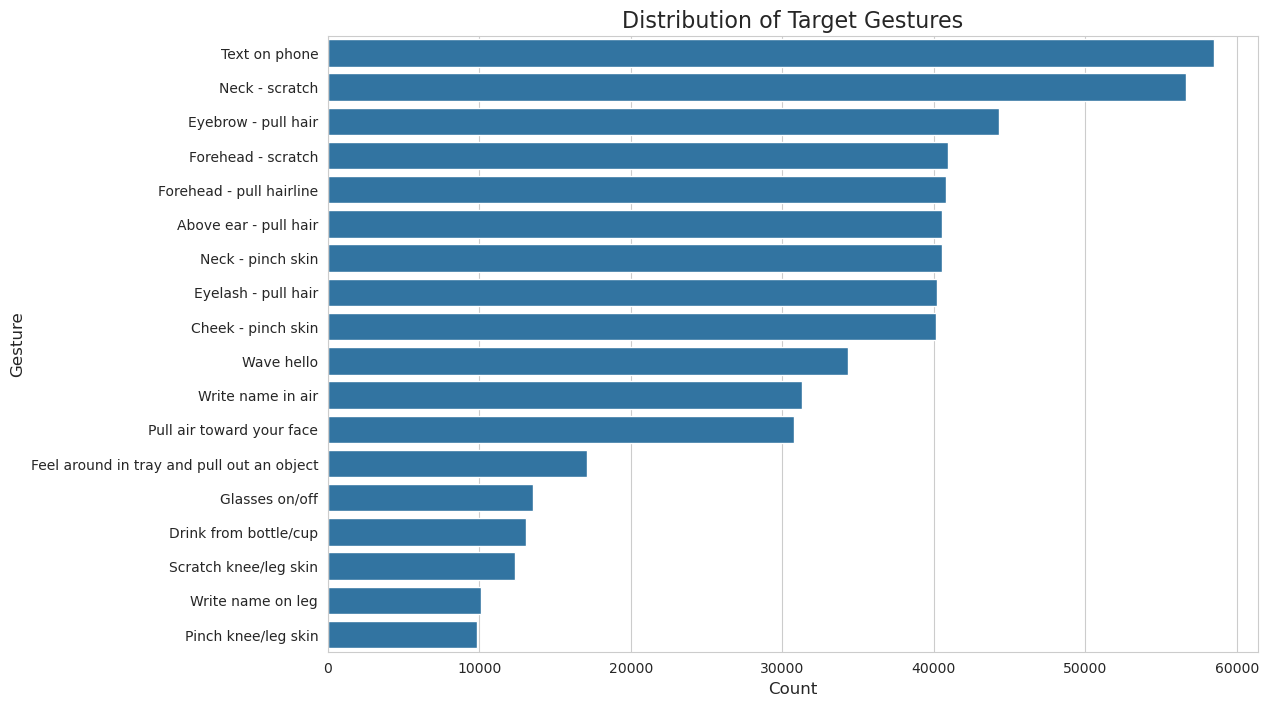

In [43]:
# Target variable distribution - Gesture
gesture = train_full['gesture']

sns.countplot(y=gesture, order=gesture.value_counts().index)
plt.title('Distribution of Target Gestures', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Gesture', fontsize=12)
plt.show();

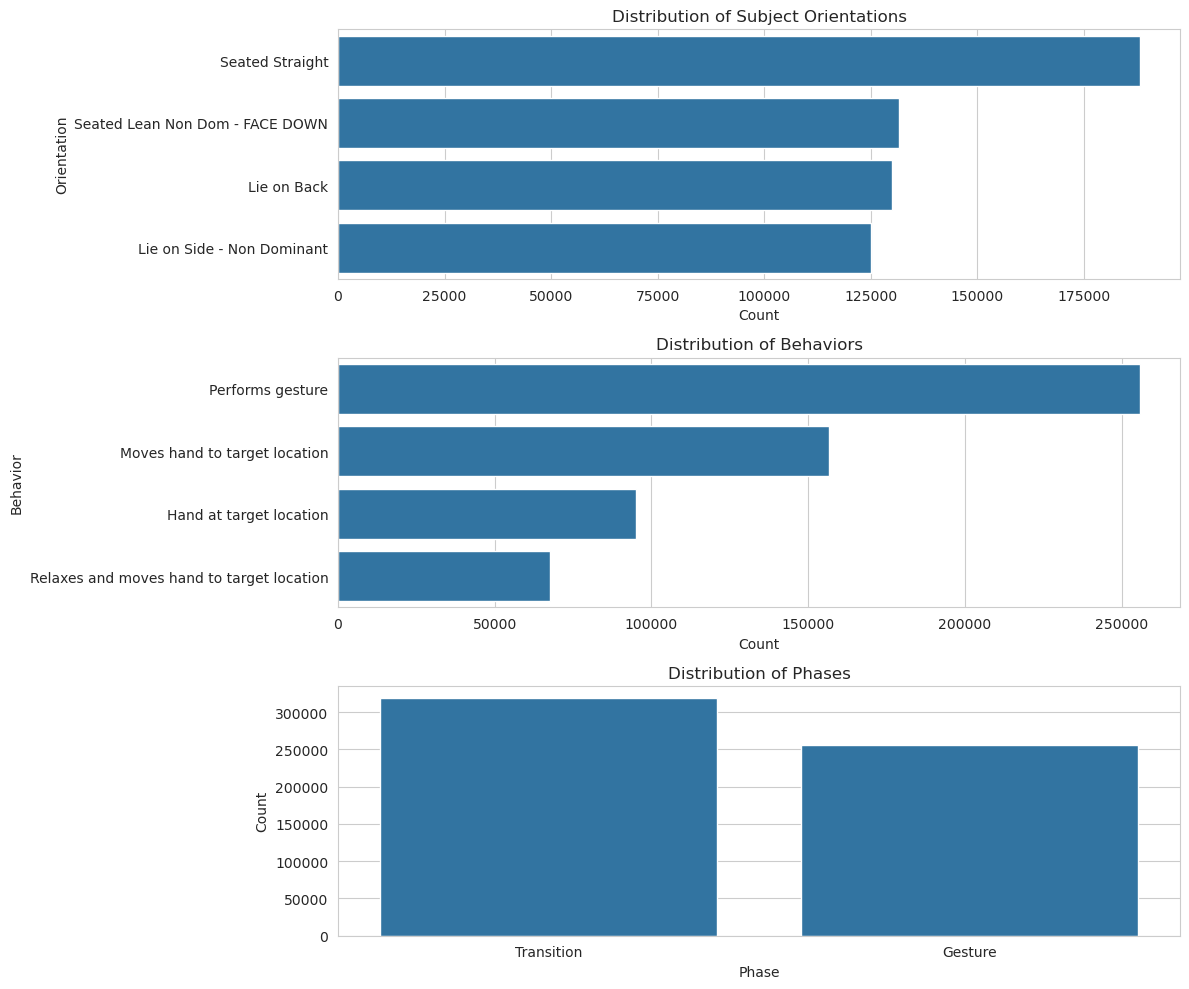

In [47]:
# Additional key variables
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

orientation = train_full['orientation']
behavior = train_full['behavior']
phase = train_full['phase']

sns.countplot(y=orientation, ax=axes[0], order = orientation.value_counts().index)
axes[0].set_title('Distribution of Subject Orientations')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Orientation')

# Behavior
sns.countplot(y=behavior, ax=axes[1], order = behavior.value_counts().index)
axes[1].set_title('Distribution of Behaviors')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Behavior')

# Phase
sns.countplot(x=phase, ax=axes[2], order = phase.value_counts().index)
axes[2].set_title('Distribution of Phases')
axes[2].set_xlabel('Phase')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show();

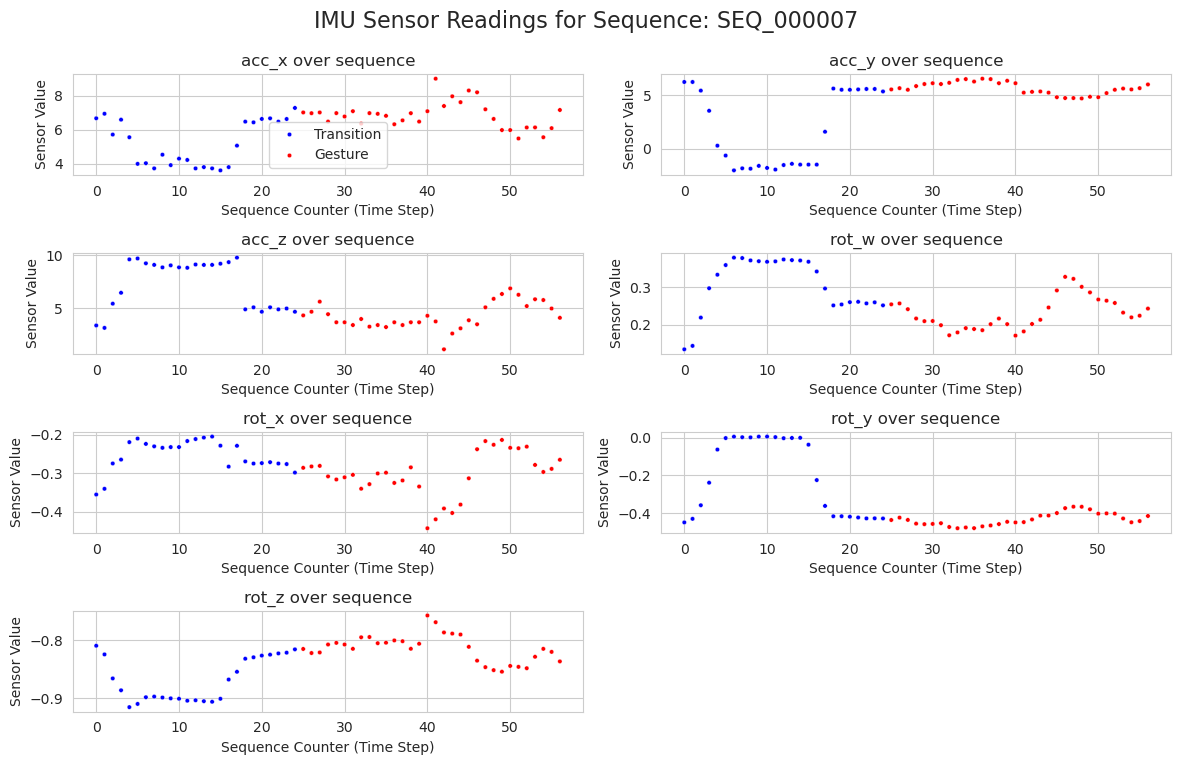

In [49]:
# Visualizing a single sequence
sample_seq = train_full['sequence_id'].iloc[10]
seq_data = train_full[train_full['sequence_id'] == sample_seq]

# Columns to plot for IMU sensors
imu_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
phase_colors = {'Transition': 'blue', 'Pause': 'green', 'Gesture': 'red'}

plt.suptitle(f'IMU Sensor Readings for Sequence: {sample_seq}', fontsize=16, y=0.95)

for i, col in enumerate(imu_cols):
    plt.subplot(4, 2, i+1)
    sns.scatterplot(data=seq_data, x='sequence_counter', y=col, hue='phase',
                    palette=phase_colors, s=10)
    plt.title(f'{col} over sequence')
    plt.xlabel('Sequence Counter (Time Step)')
    plt.ylabel('Sensor Value')
    plt.legend().set_visible(i==0) # Only show legend on the first plot

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show();